In [3]:
from save_csv import results_to_csv
import scipy.io as sio
import numpy as np
import random as sample
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
from scipy.stats import multivariate_normal as mn
%matplotlib inline

## Collectinig Data

In [4]:
data = {}
test = {}
digits = range(10)
for d in ['mnist', 'spam']:
    data_contents = sio.loadmat(d + '-data\\' + d + '_data.mat')
    data_train = data_contents['training_data']
    data_labels = data_contents['training_labels']
    data_test = data_contents['test_data']
    m = data_train.shape[0]
    n = data_train.shape[1]
    df = pd.DataFrame(data=data_train,index=list(range(m)),columns=list(range(n)))
    df['labels'] = data_labels
    data[d] = df
    test[d] = data_test

## (a) Fitting a Gaussian to Digit Classes with MLE

In [5]:
mnist_df = data['mnist']
m = mnist_df.shape[0]

In [6]:
mnist_means = [np.zeros(m) for i in digits]
mnist_covs = [_ for _ in digits]
priors = [0 for _ in digits]
for digit in digits:
    class_df = mnist_df[mnist_df['labels'] == digit]
    class_df = class_df.drop(columns='labels')
    priors[digit] = len(class_df) / m
    mean = class_df.mean(0)
    mnist_means[digit]= mean
    mnist_covs[digit] = class_df.cov()
Mu = np.vstack(mnist_means)
avg_cov = sum(mnist_covs) / 10

## (b) Visualizing Covariance Matrices

c:\users\brent\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\brent\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


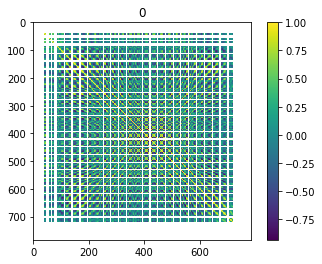

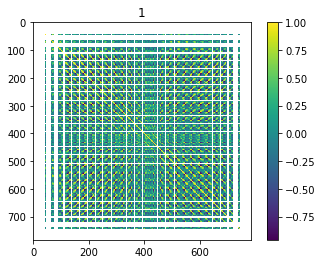

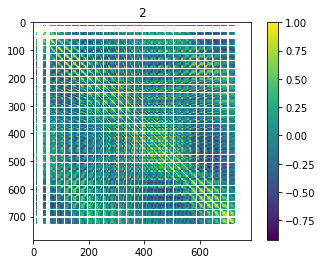

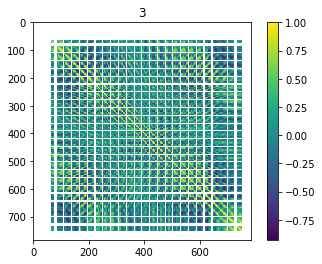

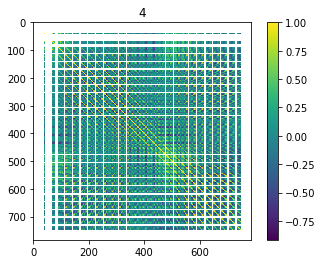

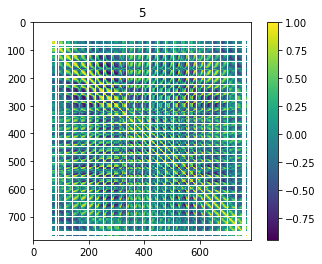

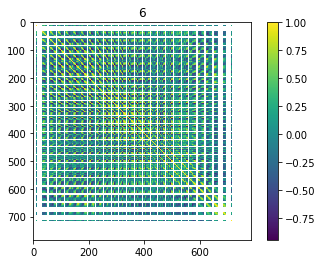

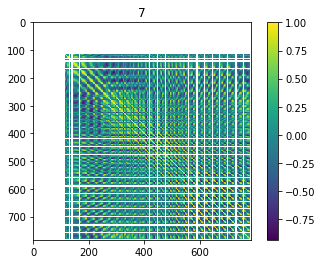

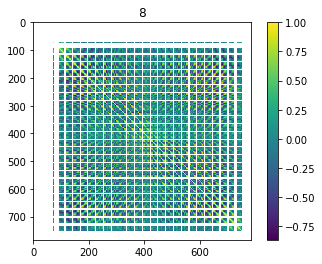

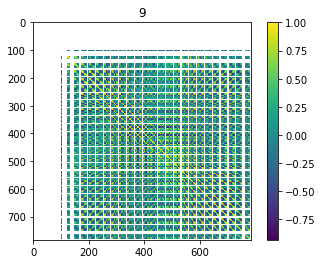

In [7]:
for digit in digits:
    plt.title(digit)
    plt.imshow(np.corrcoef(mnist_covs[digit]), interpolation='nearest')
    plt.colorbar()
    plt.show()
    

Here, we can see that the terms on the diagonal have a higher heatmap value than those off the diagonal. This demonstrates tha the variance between a feature and itself is postive, and that the variances between two different features is not as high.

## (c) Classify the digits in the test set

For LDA, the function we need to find the $argmax$ of is:
$$\mu_C^T\Sigma^{-1} x - \frac{1}{2}\mu_C^T\Sigma^{-1}\mu_C + \text{ln}\pi_C$$

In [8]:
np.dot(np.ones((2,2)),np.array([1,2]))

array([3., 3.])

In [9]:
def LDA_func(X, mu, Sigma, prior):
    n_samples = X.shape[0]
    term0 = np.dot(mu, Sigma)
    first_term = np.dot(term0,X.T)
    second_term = np.ones(n_samples) * np.dot(np.dot(mu.T, Sigma),mu)
    log_prior = np.log(np.ones(n_samples) * prior)
    scores = first_term - second_term/2 + log_prior
    return scores

For QDA, the function we need to find the $argmax$ of is:
$$\frac{1}{2}(x-\mu_C)^T\Sigma_C^{-1}(x-\mu_C) - \frac{1}{2}\text{ln}|\Sigma_C| + \text{ln}\pi_C$$

In [10]:
def QDA(X,mu,Sigma,prior):
    n_samples = X.shape[0]
    m_features = X.shape[1]
    first = (2*np.pi)**(1/(2*m_features))
    probs = mn.logpdf(X,mu,Sigma,allow_singular=True)
    return np.ones(n_samples) * np.log(first) + probs + np.ones(n_samples) * np.log(prior)

In [11]:
def make_nonsingular(X):
    U,S,V = np.linalg.svd(X)
    S_half = np.diag(1/(S*S))
    return np.matmul(np.matmul(V,S_half),V.T)

In [12]:
def train(df):
    m = df.shape[0]
    means = []
    covs = []
    priors = []
    for digit in digits:
        class_df = df[df['labels'] == digit]
        class_df = class_df.drop(columns='labels')
        means.append(class_df.mean(0))
        covs.append(class_df.cov())
        priors.append(len(class_df) / m)
    return (means,covs,priors)

In [13]:
# def avg_cov(covs):
#     return sum(covs) / 10

In [14]:
def compute_accuracy(scores, labels):
    scores = np.array(scores).T
    predictions = np.argmax(scores, axis=1)
    
    loss = 0
    
    digit_errors = [0 for _ in digits]
    digit_counts = [0 for _ in digits]
    for pred,lab in zip(predictions, labels):
        digit_counts[lab] += 1
        if pred != lab:
            loss += 1
            digit_errors[lab] +=1
    return (loss / len(predictions), [digit_errors[i]/digit_counts[i] for i in digits])

In [15]:
def digit_accuracy(scores, labels):
    
    
    scores = np.array(scores).T
    predictions = np.argmax(scores, axis=1)
    
    loss = 0
    for pred,lab in zip(predictions, labels):
        if pred != lab:
            loss += 1
    return loss / len(predictions)

In [16]:
def predict(scores):
    scores = np.vstack(scores).T
    predictions = [np.argmax(row) for row in scores]
    return predictions

## Train on different sizes

In [17]:
mnist_df = mnist_df.sample(frac=1)
mnist_val_df, mnist_train_df = mnist_df[:10000], mnist_df[10000:]
val_labels = mnist_val_df['labels'].values

In [18]:
mnist_vals = mnist_val_df.drop(columns='labels').values
m = mnist_vals.shape[0]

In [19]:
sizes =  [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
LDA_errors = []
QDA_errors = []
LDA_digit_errors = []
QDA_digit_errors = []

for approach in ['LDA', 'QDA']:
    print('-'*20)
    print(approach)
    print('-'*20)
    for size in sizes:
        print(size)
        train_df = mnist_train_df.sample(frac=1)[:size]
        means, covs, priors  = train(train_df)
        avg_cov = sum(covs) / 10
        avg_sig = make_nonsingular(avg_cov)
        scores = []
        
        for digit in digits:
            prior = priors[digit]
            mean = means[digit]
            if approach == 'LDA':
                scores.append(LDA_func(mnist_vals, mean, avg_sig, prior))
            else:
                scores.append(QDA(mnist_vals, mean, covs[digit], prior))
        
        if  approach == 'LDA':
            LDA_err, digit_errors = compute_accuracy(scores, val_labels)
            LDA_errors.append(LDA_err)
            LDA_digit_errors.append(digit_errors)
        else:
            QDA_err, digit_errors = compute_accuracy(scores, val_labels)
            QDA_errors.append(QDA_err)
            QDA_digit_errors.append(digit_errors)
    print('-'*20)

--------------------
LDA
--------------------
100
200
500
1000
2000
5000
10000
30000
50000
--------------------
--------------------
QDA
--------------------
100
200
500
1000
2000
5000
10000
30000
50000
--------------------


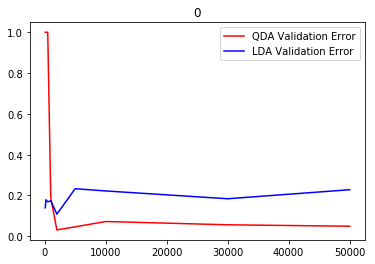

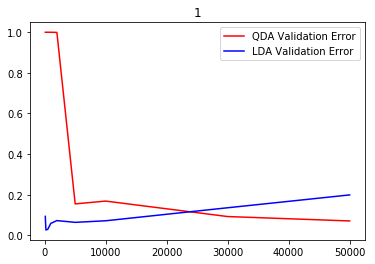

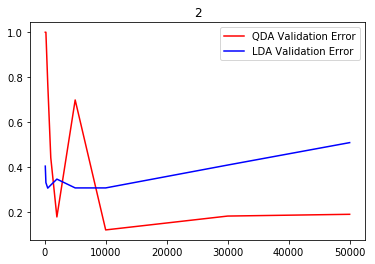

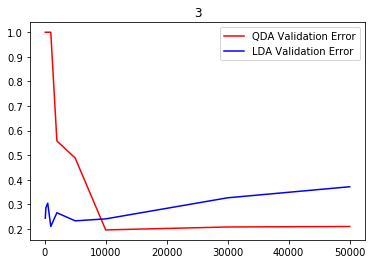

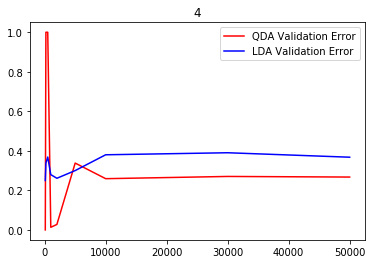

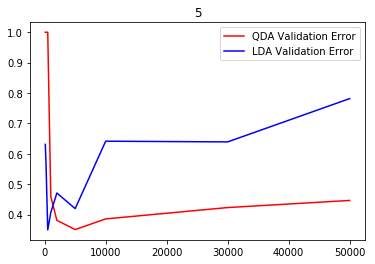

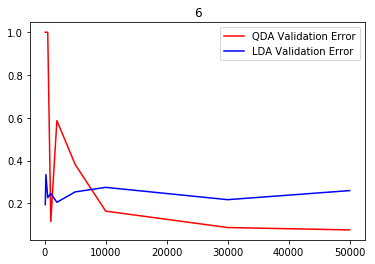

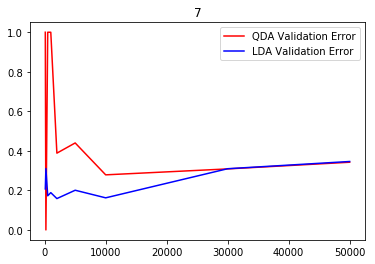

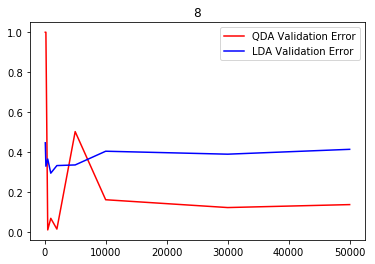

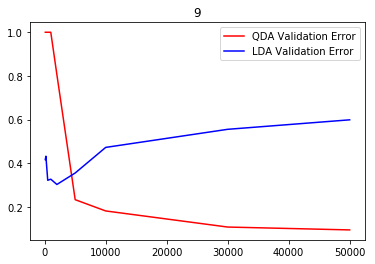

In [22]:
for digit in digits:
    plt.figure()
    plt.title(str(digit))
    plt.plot(sizes, [errors[digit] for errors in QDA_digit_errors],'r-',label='QDA Validation Error')
    plt.plot(sizes, [errors[digit] for errors in LDA_digit_errors], 'b-', label='LDA Validation Error')
    plt.legend()


#### It seems like classifying points for numbers 4,5,7 was the hardest. 

## Plotting Error Rates for LDA,QDA

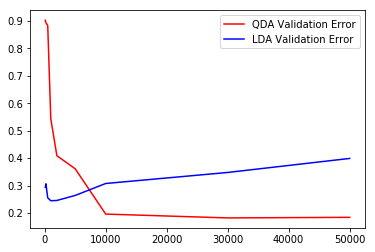

In [23]:
plt.plot(sizes, QDA_errors,'r-',label='QDA Validation Error')
plt.plot(sizes, LDA_errors, 'b-', label='LDA Validation Error')
plt.legend()

Here we see that QDA outperforms LDA for larger set sizes. Because QDA is a quadratic, it allows for much more flexibility when classifying the bigger batches of data points. For the larger training sets, it seems that QDA consistently performed better, which could be due to the fact that we compute a covariance matrix for each class, allowing for a better bias-variance tradeoff.

## Classifying Test Data

In [96]:
mnist_test = test['mnist']

In [202]:
scores = []
        
for digit in digits:
    prior = priors[digit]
    mean = means[digit]
#     Sigma = make_nonsingular(covs[digit])
    scores.append(QDA(mnist_test, mean, covs[digit], prior))
pred = predict(scores)


In [204]:
results_to_csv(np.array(pred))

## SPAM

In [215]:
spam_df = data['spam']
spam_vals = spam_df.drop(columns='labels').values


In [217]:
sizes =  [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
LDA_errors = []
QDA_errors = []

for approach in ['QDA']:
    print('-'*20)
    print(approach)
    print('-'*20)
    for size in sizes:
        print(size)
        train_df = spam_df.sample(frac=1)[:size]
        means, covs, priors  = train(train_df)
        avg_cov = sum(covs) / 2
#         avg_sig = make_nonsingular(avg_cov)
        scores = []
        
        for c in [0,1]:
            prior = priors[c]
            mean = means[c]
            if approach == 'LDA':
                scores.append(LDA_func(spam_vals, mean, avg_sig, prior))
            else:
                scores.append(QDA(spam_vals, mean, covs[c], prior))
        
#         if  approach == 'LDA':
#             LDA_errors.append(compute_accuracy(scores, val_labels))
#         else:
#             QDA_errors.append(compute_accuracy(scores, val_labels))
    print('-'*20)

--------------------
QDA
--------------------
100
200
500
1000
2000
5000
10000
30000
50000
--------------------


In [220]:
spam_test = test['spam']

In [222]:
scores = []
        
for c in [0,1]:
    prior = priors[c]
    mean = means[c]
#     Sigma = make_nonsingular(covs[digit])
    scores.append(QDA(spam_test, mean, covs[c], prior))
    pred = predict(scores)

In [224]:
results_to_csv(np.array(pred))